<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Meta-Learning_Projects/blob/main/Optimization-Based/Few_shot_Learning_MAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
import glob

import google_drive_downloader as gdd
import imageio
import numpy as np
import torch
from torch.utils.data import dataset, sampler, dataloader
from torch import nn
import torch.nn.functional as F
from torch import autograd
import matplotlib.pyplot as plt

NUM_TRAIN_CLASSES = 1100
NUM_VAL_CLASSES = 100
NUM_TEST_CLASSES = 423
NUM_SAMPLES_PER_CLASS = 20

NUM_INPUT_CHANNELS = 1
NUM_HIDDEN_CHANNELS = 64
KERNEL_SIZE = 3
NUM_CONV_LAYERS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_TEST_TASKS = 600


In [2]:
BASE_PATH = './omniglot_resized'
GDD_FILE_ID = '1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI'
gdd.GoogleDriveDownloader.download_file_from_google_drive(
                file_id=GDD_FILE_ID,
                dest_path=f'{BASE_PATH}.zip',
                unzip=True
            )

Unzipping...Done.


In [3]:
def load_image(file_path):
    """Loads and transforms an Omniglot image.
    Args:
        file_path (str): file path of image
    Returns:
        a Tensor containing image data
            shape (1, 28, 28)
    """
    x = imageio.imread(file_path)
    x = torch.tensor(x, dtype=torch.float32).reshape([1, 28, 28])
    x = x / 255.0
    return 1 - x

In [4]:
class OmniglotDataset(dataset.Dataset):
    """Omniglot dataset for meta-learning.

    Each element of the dataset is a task. A task is specified with a key,
    which is a tuple of class indices (no particular order). The corresponding
    value is the instantiated task, which consists of sampled (image, label)
    pairs.
    """

    def __init__(self, num_support, num_query):
        """Inits OmniglotDataset.

        Args:
            num_support (int): number of support examples per class
            num_query (int): number of query examples per class
        """
        super().__init__()

        # get all character folders
        self._character_folders = glob.glob(
            os.path.join(BASE_PATH, '*/*/'))
        assert len(self._character_folders) == (
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES + NUM_TEST_CLASSES
        )

        # shuffle characters
        np.random.default_rng(0).shuffle(self._character_folders)

        # check problem arguments
        assert num_support + num_query <= NUM_SAMPLES_PER_CLASS
        self._num_support = num_support
        self._num_query = num_query

    def __getitem__(self, class_idxs):
        """Constructs a task.

        Data for each class is sampled uniformly at random without replacement.
        The ordering of the labels corresponds to that of class_idxs.

        Args:
            class_idxs (tuple[int]): class indices that comprise the task

        Returns:
            images_support (Tensor): task support images
                shape (num_way * num_support, channels, height, width)
            labels_support (Tensor): task support labels
                shape (num_way * num_support,)
            images_query (Tensor): task query images
                shape (num_way * num_query, channels, height, width)
            labels_query (Tensor): task query labels
                shape (num_way * num_query,)
        """
        images_support, images_query = [], []
        labels_support, labels_query = [], []

        for label, class_idx in enumerate(class_idxs):
            # get a class's examples and sample from them
            all_file_paths = glob.glob(
                os.path.join(self._character_folders[class_idx], '*.png')
            )
            sampled_file_paths = np.random.default_rng().choice(
                all_file_paths,
                size=self._num_support + self._num_query,
                replace=False
            )
            images = [load_image(file_path) for file_path in sampled_file_paths]

            # split sampled examples into support and query
            images_support.extend(images[:self._num_support])
            images_query.extend(images[self._num_support:])
            labels_support.extend([label] * self._num_support)
            labels_query.extend([label] * self._num_query)

        # aggregate into tensors
        images_support = torch.stack(images_support)  # shape (N*S, C, H, W)
        labels_support = torch.tensor(labels_support)  # shape (N*S)
        images_query = torch.stack(images_query)
        labels_query = torch.tensor(labels_query)

        return images_support, labels_support, images_query, labels_query


In [18]:
class OmniglotSampler(sampler.Sampler):
    """Samples task specification keys for an OmniglotDataset."""

    def __init__(self, split_idxs, num_way, num_tasks):

      """Inits OmniglotSampler.

      Args:
          split_idxs (range): indices that comprise the
              training/validation/test split
          num_way (int): number of classes per task
          num_tasks (int): number of tasks to sample
      """
      super().__init__(None)

      self.split_idxs = split_idxs
      self.num_way = num_way
      self.num_tasks = num_tasks

    def __iter__(self):
      return (
          np.random.default_rng().choice(
              self.split_idxs,
              size=self.num_way,
              replace=False
          ) for _ in range(self.num_tasks)
      )

    def __len__(self):
        return self.num_tasks

In [19]:
def identity(x):
    return x

def get_omniglot_dataloader(
        split,
        batch_size,
        num_way,
        num_support,
        num_query,
        num_tasks_per_epoch
):
    """Returns a dataloader.DataLoader for Omniglot.

    Args:
        split (str): one of 'train', 'val', 'test'
        batch_size (int): number of tasks per batch
        num_way (int): number of classes per task
        num_support (int): number of support examples per class
        num_query (int): number of query examples per class
        num_tasks_per_epoch (int): number of tasks before DataLoader is
            exhausted
    """

    if split == 'train':
        split_idxs = range(NUM_TRAIN_CLASSES)
    elif split == 'val':
        split_idxs = range(
            NUM_TRAIN_CLASSES,
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES
        )
    elif split == 'test':
        split_idxs = range(
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES,
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES + NUM_TEST_CLASSES
        )
    else:
        raise ValueError

    return dataloader.DataLoader(
        dataset=OmniglotDataset(num_support, num_query),
        batch_size=batch_size,
        sampler=OmniglotSampler(split_idxs, num_way, num_tasks_per_epoch),
        num_workers=2,
        collate_fn=identity,
        pin_memory=torch.cuda.is_available(),
        drop_last=True
    )

In [20]:
image = imageio.imread("/content/omniglot_resized/Alphabet_of_the_Magi/character01/0709_01.png")
image.shape

<ipython-input-20-913cf8e1afe4>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("/content/omniglot_resized/Alphabet_of_the_Magi/character01/0709_01.png")


(28, 28)

In [47]:
samples = get_omniglot_dataloader(
        split='train',
        batch_size=1,
        num_way=4,
        num_support=1,
        num_query=1,
        num_tasks_per_epoch=1
)
tasks = next(iter(samples))
for task in tasks:
  images_support, labels_support, images_query, labels_query = task
images_support.shape, labels_support.shape, images_query.shape, labels_query.shape

<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


(torch.Size([4, 1, 28, 28]),
 torch.Size([4]),
 torch.Size([4, 1, 28, 28]),
 torch.Size([4]))

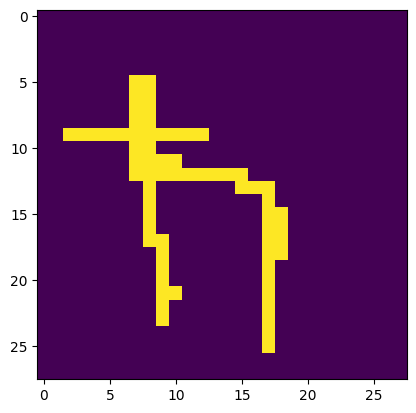

In [48]:
plt.imshow(images_support[0][0])

In [49]:
labels_support

tensor([0, 1, 2, 3])

In [ ]:
def score(logits, labels):
    """Returns the mean accuracy of a model's predictions on a set of examples.

    Args:
        logits (torch.Tensor): model predicted logits
            shape (examples, classes)
        labels (torch.Tensor): classification labels from 0 to num_classes - 1
            shape (examples,)
    """

    assert logits.dim() == 2
    assert labels.dim() == 1
    assert logits.shape[0] == labels.shape[0]
    y = torch.argmax(logits, dim=-1) == labels
    y = y.type(torch.float)
    return torch.mean(y).item()

In [ ]:
class MAML:
    """Trains and assesses a MAML."""

    def __init__(
            self,
            num_outputs,
            num_inner_steps,
            inner_lr,
            learn_inner_lrs,
            outer_lr,
            log_dir
    ):
        """Inits MAML.

        The network consists of four convolutional blocks followed by a linear
        head layer. Each convolutional block comprises a convolution layer, a
        batch normalization layer, and ReLU activation.

        Note that unlike conventional use, batch normalization is always done
        with batch statistics, regardless of whether we are training or
        evaluating. This technically makes meta-learning transductive, as
        opposed to inductive.

        Args:
            num_outputs (int): dimensionality of output, i.e. number of classes
                in a task
            num_inner_steps (int): number of inner-loop optimization steps
            inner_lr (float): learning rate for inner-loop optimization
                If learn_inner_lrs=True, inner_lr serves as the initialization
                of the learning rates.
            learn_inner_lrs (bool): whether to learn the above
            outer_lr (float): learning rate for outer-loop optimization
            log_dir (str): path to logging directory
        """
        meta_parameters = {}

        # construct feature extractor
        in_channels = NUM_INPUT_CHANNELS
        for i in range(NUM_CONV_LAYERS):
            meta_parameters[f'conv{i}'] = nn.init.xavier_uniform_(
                torch.empty(
                    NUM_HIDDEN_CHANNELS,
                    in_channels,
                    KERNEL_SIZE,
                    KERNEL_SIZE,
                    requires_grad=True,
                    device=DEVICE
                )
            )
            meta_parameters[f'b{i}'] = nn.init.zeros_(
                torch.empty(
                    NUM_HIDDEN_CHANNELS,
                    requires_grad=True,
                    device=DEVICE
                )
            )
            in_channels = NUM_HIDDEN_CHANNELS

        # construct linear head layer
        meta_parameters[f'w{NUM_CONV_LAYERS}'] = nn.init.xavier_uniform_(
            torch.empty(
                num_outputs,
                NUM_HIDDEN_CHANNELS,
                requires_grad=True,
                device=DEVICE
            )
        )
        meta_parameters[f'b{NUM_CONV_LAYERS}'] = nn.init.zeros_(
            torch.empty(
                num_outputs,
                requires_grad=True,
                device=DEVICE
            )
        )

        self._meta_parameters = meta_parameters
        self._num_inner_steps = num_inner_steps
        self._inner_lrs = {
            k: torch.tensor(inner_lr, requires_grad=learn_inner_lrs)
            for k in self._meta_parameters.keys()
        }
        self._outer_lr = outer_lr

        self._optimizer = torch.optim.Adam(
            list(self._meta_parameters.values()) +
            list(self._inner_lrs.values()),
            lr=self._outer_lr
        )
        # self._log_dir = log_dir
        # os.makedirs(self._log_dir, exist_ok=True)

        self._start_train_step = 0

    def _forward(self, images, parameters):
        """Computes predicted classification logits.

        Args:
            images (Tensor): batch of Omniglot images
                shape (num_images, channels, height, width)
            parameters (dict[str, Tensor]): parameters to use for
                the computation

        Returns:
            a Tensor consisting of a batch of logits
                shape (num_images, classes)
        """
        x = images
        for i in range(NUM_CONV_LAYERS):
            x = F.conv2d(
                input=x,
                weight=parameters[f'conv{i}'],
                bias=parameters[f'b{i}'],
                stride=1,
                padding='same'
            )
            x = F.batch_norm(x, None, None, training=True)
            x = F.relu(x)
        x = torch.mean(x, dim=[2, 3])
        return F.linear(
            input=x,
            weight=parameters[f'w{NUM_CONV_LAYERS}'],
            bias=parameters[f'b{NUM_CONV_LAYERS}']
        )

    def _inner_loop(self, images, labels, train):
        """Computes the adapted network parameters via the MAML inner loop.

        Args:
            images (Tensor): task support set inputs
                shape (num_images, channels, height, width)
            labels (Tensor): task support set outputs
                shape (num_images,)
            train (bool): whether we are training or evaluating (not necessary?)

        Returns:
            parameters (dict[str, Tensor]): adapted network parameters
            accuracies (list[float]): support set accuracy over the course of
                the inner loop, length num_inner_steps + 1
        """
        accuracies = []
        parameters = {
            k: torch.clone(v)
            for k, v in self._meta_parameters.items()
        }
        # This method computes the inner loop (adaptation) procedure for one
        # task. It also scores the model along the way.
        # Populate accuracies and update parameters.
        # F.cross_entropy to compute classification losses.
        # score() to compute accuracies.

        # here we are doing \phi_i = \theta - inner_lr * grad(\theta, L, D_{tr})
        for _ in range(self._num_inner_steps):
            logits = self._forward(images, parameters)
            loss = F.cross_entropy(logits, labels)

            # create graph due to computing second order derivatives in MAML
            gradients = autograd.grad(
                loss, parameters.values(), create_graph=True)

            # update parameters
            for i in range(len(parameters.keys())):
                k = list(parameters.keys())[i]
                v = list(parameters.values())[i]
                assert v.shape == gradients[i].shape, 'Not proper shape'

                parameters[k] = v - self._inner_lrs[k] * gradients[i]

            acc = score(logits, labels)
            accuracies.append(acc)

        final_logits = self._forward(images, parameters)
        final_acc = score(final_logits, labels)
        accuracies.append(final_acc)
        return parameters, accuracies

    def _outer_step(self, task_batch, train):
        """Computes the MAML loss and metrics on a batch of tasks.

        Args:
            task_batch (tuple): batch of tasks from an Omniglot DataLoader
            train (bool): whether we are training or evaluating

        Returns:
            outer_loss (Tensor): mean MAML loss over the batch, scalar
            accuracies_support (ndarray): support set accuracy over the
                course of the inner loop, averaged over the task batch
                shape (num_inner_steps + 1,)
            accuracy_query (float): query set accuracy of the adapted
                parameters, averaged over the task batch
        """
        outer_loss_batch = []
        accuracies_support_batch = []
        accuracy_query_batch = []
        for task in task_batch:
            images_support, labels_support, images_query, labels_query = task
            images_support = images_support.to(DEVICE)
            labels_support = labels_support.to(DEVICE)
            images_query = images_query.to(DEVICE)
            labels_query = labels_query.to(DEVICE)
            # For a given task, use the _inner_loop method to adapt, then
            # compute the MAML loss and other metrics.
            # F.cross_entropy to compute classification losses.
            # score() to compute accuracies.
            # Populate outer_loss_batch, accuracies_support_batch,
            # and accuracy_query_batch.

            # computes \phi_L
            parameters, supp_accs = self._inner_loop(
                images_support, labels_support, train)

            # gets the loss w.r.t. \phi_L
            logits = self._forward(images_query, parameters)
            loss = F.cross_entropy(logits, labels_query)
            outer_loss_batch.append(loss)

            accuracies_support_batch.append(supp_accs)
            q_accs = score(logits, labels_query)
            accuracy_query_batch.append(q_accs)

        outer_loss = torch.mean(torch.stack(outer_loss_batch))
        accuracies_support = np.mean(
            accuracies_support_batch,
            axis=0
        )
        accuracy_query = np.mean(accuracy_query_batch)
        return outer_loss, accuracies_support, accuracy_query